In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy

## Linear Models

A standard problem in statistics to solve the multivariate linear regression problem.
\begin{equation}
y = X * \beta + \epsilon
\end{equation}
The above notation is standard in statistics, but in our discussion (and codes) we will replace $\beta$ with `b`
```
y = X * b + eps.
```
`X` is known as the [design matrix](https://en.wikipedia.org/wiki/Design_matrix), and consists of `n` rows of observations, each of which has `p` features (so it is an $n\times p$ matrix).  `y` is a vector of `n` responses.  `b` is an unknown vector of `p` coefficients which we would like to find.  `eps` (epsilon) is a vector of length `n` with random noise, typically i.i.d. normally distributed with variance `sig` (sigma).

In numpy notation, we could express this as
```python
y[i] = np.dot(X[i], b) + sig * np.random.randn()
```

We want to determine `b`, so that when me make a new observation `X[n]` we can predict the response `y[n]`.  One way to do this is to minimize the mean square error

\begin{equation}
\mathop{\mathsf{minimize}}_b \mathbb{E}((X[n]*b - y[n])^2)
\end{equation}

The solution to this is the solution to the least squares problem
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X*b - y\|_2^2
\end{equation}

Where $n$ is the number of rows in $X$.  We'll let the solution to the problem be denoted $\hat{b}$, or `bhat`.

## Problem 0 - Linear Regression (37 points)

There are a variety of ways to solve the above problem.  We will assume that $n > p$, meaning there are more observations than features.

### Part A: Generating Data (5 points)

Write a function `gen_lstsq(n, p, sig=0.1)` which will generate a linear least squares problem (return `X`, `y`, and `b` as described above).  `b` is the "ground truth" coefficients that we are looking for.  You can generate the matrix `X` using `np.random.randn`, and generate `b` using `np.random.randn` as well. 


In [4]:
def gen_lstsq(n, p, sig=0.1):
    """
    generate a linear least squares problem
    """
    
    # design matrix
    X = np.random.rand(n, p)
    
    # coefficients
    b = np.random.rand(p, 1)
    
    # add random noises
    y = X @ b + sig * np.random.randn(n, 1)
    
    return X, y, b

### Part B: QR factorization (3 points)

If we form a QR factorization $X = QR$, we can find $\hat{b} = R^{-1} Q^T y$.

Write a function `solve_lstsq_qr(X, y)` which estimates `b` using the QR factorization as above. 

In [9]:
def solve_lstsq_qr(X, y):
    """
    solve linear model using QR
    """
    
    Q, R = la.qr(X, mode='economic')
    bhat = la.solve_triangular(R, Q.T @ y, lower=False)
    
    return bhat

### Part C: Normal Equations (3 points)

Often, this is the way statistics textbooks solve the problem: $\hat{b} = (X^T X)^{-1} X^T y$.  This is based on the normal equation $X^T X \hat{b} = X^T y$.

Write a function `solve_lstsq_normal(X, y)` which estimates `b` using the normal equations above. Note that forming the full inverse would be slow and unstable. Instead, you should try to apply $(X^TX)^{-1}$ by forming a Cholesky factorization instead.

In [10]:
def solve_lstsq_normal(X, y):
    """
    solve linear model using normal equations
    """
    
    L = la.cholesky(X.T @ X, lower=True)
    
    bhat = la.solve_triangular(
        L.T,
        la.solve_triangular(
            L,
            X.T @ y,
            lower=True
        ),
        lower=False
    )
    
    return bhat
    

### Part D: Check Your Work (3 points)

Generate a few random problems to test that `solve_lstsq_qr` and `solve_lstsq_normal` give the same prediction $\hat{b}$ (measure $\|\hat{b}_{qr} - \hat{b}_{normal}\|_2$ and check it is smaller than `1e-4`).  Use $n > p$.  Check against `solve_lstsq` in numpy or scipy as well.

Text(0, 0.5, 'errors')

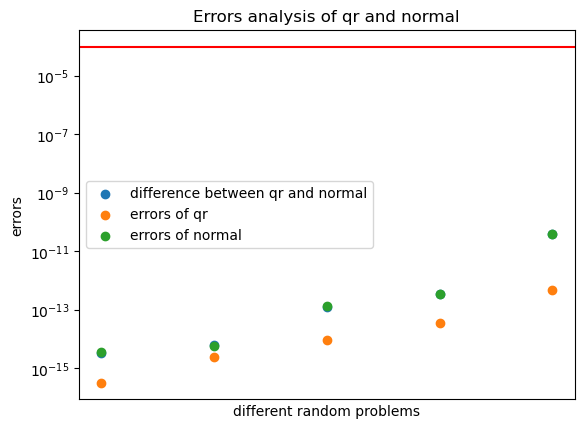

In [46]:
# generate random problems
ns = [10, 20, 50, 100, 1000]
ps = [5, 10, 25, 50, 500]
errors = []

for n, p in zip(ns, ps):
    
    X, y, b = gen_lstsq(n, p)
    
    # solve for bhat
    bhat_qr = solve_lstsq_qr(X, y)
    bhat_normal = solve_lstsq_normal(X, y)
    bhat_scipy = la.lstsq(X, y)[0]
    
    errors.append([la.norm(bhat_qr - bhat_normal),
                   la.norm(bhat_qr - bhat_scipy),
                   la.norm(bhat_normal - bhat_scipy)])

# prepare for plotting
errors_between = [i[0] for i in errors]
errors_qr = [i[1] for i in errors]
errors_normal = [i[2] for i in errors]

plt.scatter(range(5), errors_between, label='difference between qr and normal')
plt.scatter(range(5),errors_qr, label='errors of qr')
plt.scatter(range(5),errors_normal, label='errors of normal')
plt.axhline(y=1e-4, color='r')
plt.yscale('log')
plt.title("Errors analysis of qr and normal")
plt.xticks([])
plt.legend()
plt.xlabel("different random problems")
plt.ylabel("errors")

As we can see all errors are below 10^-4, so we can say all algorithms are performing as expected.

### Part E: Estimate the Error (6 points)

Write a function `err` which estimates the error in your fit using the equation $\frac{1}{n}\|X * \hat{b} - y\|_2^2$. The function should have the call signature `err(X,y,bhat).` 

Create a plot of the error vs the noise parameter `sig` (i.e. use your code from the previous parts to generate $y,$ $\hat{b},$ and $X$ for various $\sigma \in[10^{-4},10]$ and use `err` to compute the corresponding error).  Use `n=100`, `p=50` when generating data.  Put your plot on log-log axes.  Give it a title and axis labels.

As above, you should generate `X` to be `N x p` using `np.random.randn`, and set `y = X * b + sig * np.random.randn(p)`. Note: when choosing `sig` on $[10^{-4},10]$ it would help if you gave them a logarithmic distribution (like taking equispaced points $t_0,\dots,t_N$ between -4 and 1, and setting $\sigma_0 =10^{t_0},\dots, \sigma_N = 10^{t_n}.$

Try to make smoother plots by averaging the error over several trials.


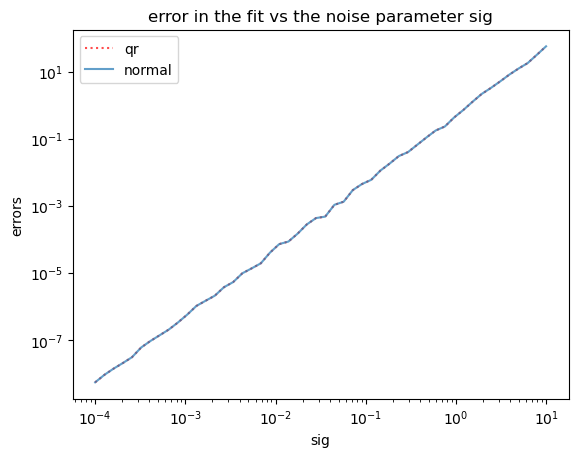

In [55]:
def err(X, y, bhat):
    """
    estimates the error in the fit
    """
    
    return (1/len(y)) * (la.norm(X @ bhat - y)**2)


sigs = np.logspace(-4, 1, num=50)
errs_qr = []
errs_normal = []

for sig in sigs:
    error_qr = 0
    error_normal = 0
    
    # averaging over 5 runs
    for i in range(5):
        X, y, b = gen_lstsq(100, 50, sig=sig)
        bhat_qr = solve_lstsq_qr(X, y)
        error_qr += err(X, y, bhat_qr)
        bhat_normal = solve_lstsq_normal(X, y)
        error_normal += err(X, y, bhat_normal)
        
    errs_qr.append(error_qr/5)
    errs_normal.append(error_normal/5)
    

plt.loglog(sigs, errs_qr, label='qr', linestyle=':', alpha=0.7, color='red')
plt.loglog(sigs, errs_normal, label='normal', linestyle='-', alpha=0.7)
plt.title("error in the fit vs the noise parameter sig")
plt.xlabel("sig")
plt.ylabel("errors")
plt.legend()
plt.show()

### Part F: Discussion (10 points)

Which of `solve_lstsq_qr` and `solve_lstsq_normal` is faster?  Give a justification for your answer (e.g. in terms of what you know about time to compute matrix multiplication and factorizations as a function of $n$ and $p$).

Suppose that $\kappa(X)$ is large. Which of `solve_lstsq_qr` and `solve_lstsq_normal` will be more stable? i.e. which of $\hat{b} = R^{-1} Q^T y$ and $\hat{b} = (X^T X)^{-1} X^T y$ has a smaller condition number? Use the fact that the matrix condition number satisfies
$$
\kappa(A^{-1}) = \kappa(A), \qquad \kappa(A^T) = \kappa(A), \qquad \kappa(AB) \approx \kappa(A)\kappa(B),
$$
and that
$$
\kappa(Q) = 1
$$
because the columns of $Q$ are orthonormal. You should also use the fact that for most $A$ and $B$
$$
\kappa(AB) \approx \kappa(A)\kappa(B).
$$
Note that there are counter examples, e.g. $1=\kappa(I)=\kappa(AA^{-1})< \kappa(A)\kappa(A^{-1})=\kappa(A)^2$ whenever $\kappa(A)>1$.

1. The complexity of QR decomposition is $O(n \cdot p^2)$ and matrix multiplication is $O(np)$. Then solving $Rb = Q^{\mathrm{T}}y$ has the cost of solving a triangular system $O(p^2)$. The overall computational complexity is $O(n \cdot p^2) + O(p^2) + O(np)$. 

The complexity of Cholesky factorizatioin is $O(p^3)$ and the matrix multiplication is $O(p^2 \cdot n)$. The cost of solving a triangular system is $O(p^2)$ and $X^{\mathrm{T}} y$ costs $O(np)$. The overall computational complexity is $O(p^2 \cdot n) + O(p^2) + O(p^3) + O(np)$ 

Based on my analysis, QR decomposition is faster.

2. $\kappa(R^{-1}Q^{\mathrm{T}}) \approx \kappa(R^{-1})\kappa(Q) = \kappa(R) = \kappa(X)$

$\kappa\left(\left(X^T X\right)^{-1} X^T\right)=\kappa\left(\left(X^T X\right)^{-1}\right) \kappa\left(X^T\right) \approx \kappa\left(X^T X\right) \kappa\left(X^T\right) = \kappa(X)^2\kappa(X) = \kappa(X)^3$

Thus QR decomposition has smaller condition number if we suppose $\kappa(X)$ is large, so it's more stable.

### Part G: Optimization (5 points)

Solve the minimization problem 
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2
\end{equation}

using `scipy.optimize.minimize`.  Wrap this in a function `solve_lstsq_opt(X, y)`.  Note that you can define the objective function inside `solve_lstsq_opt`

**Jacobian**: you should implement the Jacobian of the objective function to use in the optimization problem.  Here's a derivation:  We'd like to minimize the objective function
\begin{equation}
n f(b) = \|X*b - y\|_2^2 = (Xb - y)^T (Xb - y) = b^T X^T X b - 2 y^T X b + y^T y
\end{equation}

We might write the above expression as
\begin{equation}
n f(b) \sum_{i,j} b_i (X^T X)_{i,j} b_j - 2\sum_{j,i} y_i X_{i,j} b_j + y^T y
\end{equation}

We can take a derivative with respect to $b_j$
\begin{equation}
n \frac{\partial f}{\partial b_j} = \sum_{i\ne j} b_i (X^T X)_{i,j} + \sum_{i\ne j} (X^T X)_{j,i} b_i + 2 (X^T X)_{j,j} b_j  - 2\sum_{i} y_i X_{i,j}
\end{equation}

Putting this in matrix form, we obtain
\begin{equation}
J_f(b) =  \frac{1}{n}\big( b^T (X^T X) + b^T (X^T X)^T - 2y^T X\big) = \frac{2}{n} b^T (X^T X) -\frac{2}{n}y^T X
\end{equation}

So we can write $J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X$

In [203]:
import scipy.optimize as opt

def solve_lstsq_opt(X, y):
    """
    solve the minimization problem using optimization
    """
    
    n, p = X.shape
    f = lambda b: (1/n) * np.sum((X @ b.reshape(-1, 1) - y)**2)
    Jf = lambda b: (2/n) * (b.reshape(1, -1) @ (X.T @ X) - y.T @ X).ravel()
    
    sol = opt.minimize(f, np.zeros(p), jac=Jf)
    
    return sol.x.reshape(-1,1)




#### Check Your Work

Generate a few random problems to test that `solve_lstsq_opt` agrees with `solve_lstsq_qr` and `solve_lstsq_normal` in part A.  Use the same tolerance for checking.

Text(0, 0.5, 'errors')

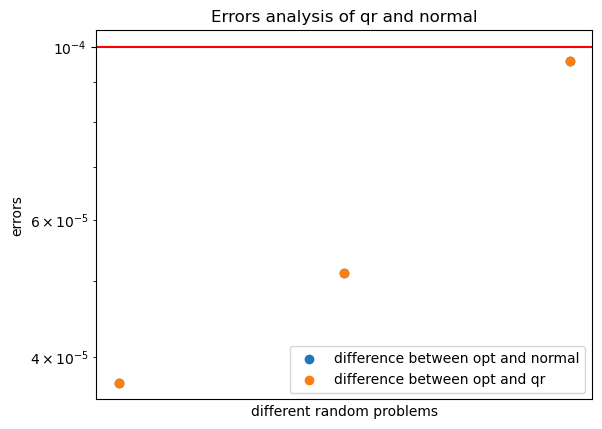

In [209]:
ns = [10, 20, 50]
ps = [5, 10, 15]
errors_qr = []
errors_normal = []

for n, p in zip(ns, ps):
    X, y, b = gen_lstsq(n, p)
    
    bhat_opt = solve_lstsq_opt(X, y)
    bhat_qr = solve_lstsq_qr(X, y)
    bhat_normal = solve_lstsq_normal(X, y)
    
    errors_qr.append(la.norm(bhat_opt - bhat_qr))
    errors_normal.append(la.norm(bhat_opt - bhat_normal))
    
plt.scatter(range(len(ns)), errors_normal, label='difference between opt and normal')
plt.scatter(range(len(ns)), errors_qr, label='difference between opt and qr')
plt.axhline(y=1e-4, color='r')
plt.yscale('log')
plt.title("Errors analysis of qr and normal")
plt.xticks([])
plt.legend()
plt.xlabel("different random problems")
plt.ylabel("errors")

Opt is not very stable and sometimes differs a lot (>1e4) from the other two.

### Part H: Discussion (2 points)

How fast is `solve_lstsq_opt` compared to the functions you wrote in part A?  Give some justification for what you see.

In [188]:
%%time
for i in range(50):
    X, y, b = gen_lstsq(100, 50)
    solve_lstsq_opt(X, y)

CPU times: user 219 ms, sys: 2.93 ms, total: 222 ms
Wall time: 225 ms


In [189]:
%%time
for i in range(50):
    X, y, b = gen_lstsq(100, 50)
    solve_lstsq_qr(X, y)

CPU times: user 21.7 ms, sys: 1.85 ms, total: 23.5 ms
Wall time: 23.1 ms


In [190]:
%%time
for i in range(50):
    X, y, b = gen_lstsq(100, 50)
    solve_lstsq_normal(X, y)

CPU times: user 12.4 ms, sys: 2.46 ms, total: 14.8 ms
Wall time: 24.9 ms


Optimization is significantly slower compared to the other two methods; it takes 10 times longer than both the normal and QR methods

## Problem 1 - Ridge Regression (13 points)

We'll now turn to the problem of what to do when `n < p` (there are now fewer observations than features).  In this case we can find a $b$ which satisfies the equation $X * b = y$ exactly, but there are many possible values of $b$ which can satisfy the equation.

As we discussed in class, we can change the problem to try to make it unique. One simple way of doing this is to add an additional term to our optimization problem. Ridge regression is one such approach.

Ridge regression seeks to solve the following optimization problem:

\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2 + \lambda \|b\|_2^2
\end{equation}

$\lambda$ is a parameter you can choose to "regularize" the problem which you can choose.

### Part A: Optimization (9 points)

Use `scipy.optimize.minimize` to minimize the above optimization problem.  Wrap this in a function `solve_ridge_opt(X, y, lam=0.1)` (`lam` should be provided as a keyword argument for the variable $\lambda$).

What is the Jacobian for the objective function for the minimization problem?  Incorporate this into your optimization problem.  Hint: differentiation is linear, so you just need to add a term to the Jacobian in Problem 0 based on the Jacobian of
\begin{equation}
\lambda \|b\|_2^2 = \lambda b^T b = \lambda \sum_i b_i^2
\end{equation}

---


In [191]:
def solve_ridge_opt(X, y, lam=0.1):
    """
    solve optimization using ridge
    """
    n, p = X.shape
    f = lambda b: (1/n) * np.sum((X @ b.reshape(-1, 1) - y)**2) + lam * np.sum(b**2)
    Jf = lambda b: (2/n) * (b.reshape(1, -1) @ (X.T @ X) - y.T @ X).ravel() + 2 * lam * b 
    
    sol = opt.minimize(f, np.zeros(p), jac=Jf)
    
    return sol.x.reshape(-1,1)

### Part B: Compute the error (4 points)

Set `n = 50`, `p=100`, and `sig=0.1`.  Make a plot that displays the error of `bhat` computed using `solve_ridge_opt` as `lam` varies between `1e-4` and `1e2` (see Problem 0, Part E).  Use a `semilogx` plot.

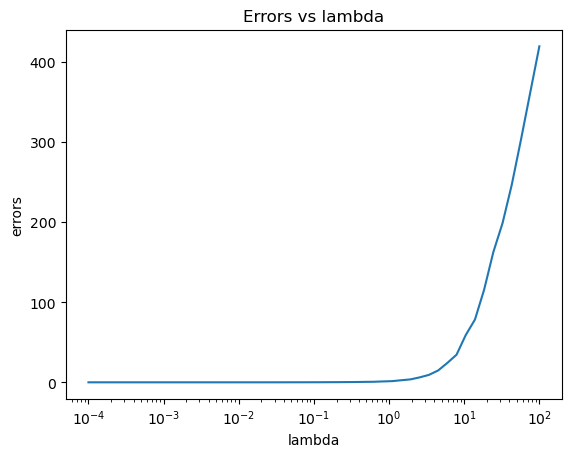

In [192]:
def err(X, y, bhat):
    
    return (1/len(y)) * (np.linalg.norm(X @ bhat - y)**2)


lams = np.logspace(-4, 2, num=50)
errs = []

for lam in lams:
    error = 0
    
    for i in range(5):
        X, y, b = gen_lstsq(50, 100)
        bhat_opt = solve_ridge_opt(X, y, lam=lam)
        error += err(X, y, bhat_opt)
        
    errs.append(error/5)

plt.semilogx(lams, errs)
plt.xlabel('lambda')
plt.ylabel('errors')
plt.title('Errors vs lambda')
plt.show()